In [115]:
# import packages
import io
import lyricsgenius
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from nltk.probability import FreqDist
import nltk
from nltk.util import pad_sequence
from nltk.util import bigrams
from nltk.util import ngrams
from nltk.util import everygrams
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.lm.preprocessing import flatten
from nltk.util import pad_sequence
from nltk.lm.preprocessing import pad_both_ends
from nltk.lm.preprocessing import flatten
from nltk.corpus import stopwords
from nltk.lm import Vocabulary
from nltk.tokenize import word_tokenize 
from nltk.tokenize import ToktokTokenizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk import sent_tokenize 
from nltk import PorterStemmer
from collections import Counter
from nltk.lm import MLE
import string
import re

## Songs Import

In [85]:
genius = lyricsgenius.Genius("my token")
genius.remove_section_headers = True
genius.excluded_terms = ["(Remix)", "(Live)", "(Radio Edit)", "(Türkçe Çeviri)"]

In [ ]:
#ran code in collab & saved to txt
artist = genius.search_artist('Eminem', sort='popularity', max_songs=150)
artist.save_lyrics(extension = 'txt')

In [2]:
#open file with 150 songs
file = open('Lyrics_Eminem.txt')
lyrics = file.read()

## Prepare & look at data

In [210]:
df = pd.DataFrame({'lyrics': io.open('Lyrics_Eminem.txt', 'r', encoding='ascii', errors='ignore').read().split('\n\n')})

In [214]:
# characters, words, lines, unique words, density
df['#characters'] = df.lyrics.str.len()
df['#words'] = df.lyrics.str.split().str.len()
df['#lines'] = df.lyrics.str.split('\n').str.len()
df['#uniq_words'] = df.lyrics.apply(lambda x: len(set(x.split())))
df['lexical_density'] = df['#uniq_words'] / df['#words']
df.head()

,lyrics,#characters,#words,#lines,#uniq_words,lexical_density
0,"""Look, I was gonna go easy on you not to hurt ...",459,87,7,76,0.873563
1,"I'm beginnin' to feel like a Rap God, Rap God\...",215,46,4,38,0.826087
2,But for me to rap like a computer it must be i...,1083,205,23,146,0.712195
3,"'Cause I'm beginnin' to feel like a Rap God, R...",311,61,5,50,0.819672
4,"Well, to be truthful the blueprint's\nSimply r...",1467,282,32,190,0.673759


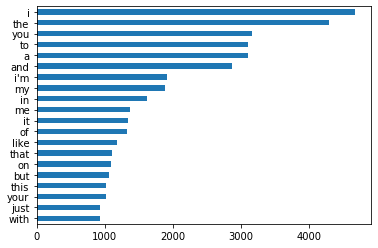

In [217]:
# top short words
pd.Series(' '.join(df.lyrics).lower().split()).value_counts()[:20][::-1].plot(kind='barh')

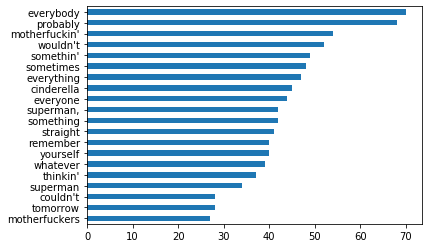

In [218]:
# top long words
pd.Series([w for w in ' '.join(df.lyrics).lower().split() if len(w) > 7]).value_counts()[:20][::-1].plot(kind='barh')

In [215]:
# tokenize by sentence
sentences = sent_tokenize(lyrics)

In [216]:
# tokenize by word in a sentence
tokenized_sentences = [list(map(str.lower, word_tokenize(sent))) 
                  for sent in sent_tokenize(lyrics)]

In [189]:
# train/test split
train, test = train_test_split(tokenized_sentences, test_size = 0.2, random_state = 1)

## Models

#### N-grams

In [7]:
# define function to clean generated text
def generate_sent(model, num_words, random_seed = 1):
    detokenize = TreebankWordDetokenizer().detokenize
    content = []
    for token in model.generate(num_words, random_seed=random_seed):
        if token == '<s>':
            continue
        if token == '</s>':
            break
        content.append(token)
    return detokenize(content)

In [22]:
# define function to form a text from model result
# pretty sure it can be done much easier and results actually suck

abbreviations = {'dr.': 'doctor', 'mr.': 'mister', 'bro.': 'brother', 'bro': 'brother', 'mrs.': 'mistress', 'ms.': 'miss', 'jr.': 'junior', 'sr.': 'senior',
                 'i.e.': 'for example', 'e.g.': 'for example', 'vs.': 'versus'}
terminators = ['.', ',', '!', '?', ')']
wrappers = ['"', "'", ')', ']', '}']
def find_sentences(paragraph):
   end = True
   sentences = []
   while end > -1:
       end = find_sentence_end(paragraph)
       if end > -1:
           sentences.append(paragraph[end:].strip())
           paragraph = paragraph[:end]
   sentences.append(paragraph)
   sentences.reverse()
   return sentences

def find_sentence_end(paragraph):
    [possible_endings, contraction_locations] = [[], []]
    contractions = abbreviations.keys()
    sentence_terminators = terminators + [terminator + wrapper for wrapper in wrappers for terminator in terminators]
    for sentence_terminator in sentence_terminators:
        t_indices = list(find_all(paragraph, sentence_terminator))
        possible_endings.extend(([] if not len(t_indices) else [[i, len(sentence_terminator)] for i in t_indices]))
    for contraction in contractions:
        c_indices = list(find_all(paragraph, contraction))
        contraction_locations.extend(([] if not len(c_indices) else [i + len(contraction) for i in c_indices]))
    possible_endings = [pe for pe in possible_endings if pe[0] + pe[1] not in contraction_locations]
    if len(paragraph) in [pe[0] + pe[1] for pe in possible_endings]:
        max_end_start = max([pe[0] for pe in possible_endings])
        possible_endings = [pe for pe in possible_endings if pe[0] != max_end_start]
    possible_endings = [pe[0] + pe[1] for pe in possible_endings if sum(pe) > len(paragraph) or (sum(pe) < len(paragraph) and paragraph[sum(pe)] == ' ')]
    end = (-1 if not len(possible_endings) else max(possible_endings))
    return end

def find_all(a_str, sub):
    start = 0
    while True:
        start = a_str.find(sub, start)
        if start == -1:
            return
        yield start
        start += len(sub)

### Bigram model

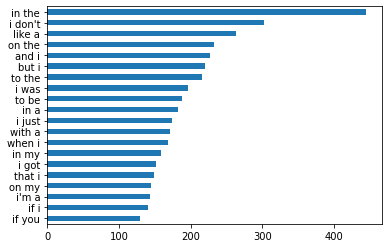

In [220]:
# most common ngrams
def get_ngrams_from_series(series, n=2):
    lines = ' '.join(series).lower().split('\n')
    lgrams = [ngrams(l.split(), n) for l in lines]
    grams = [[' '.join(g) for g in list(lg)] for lg in lgrams]
    return [item for sublist in grams for item in sublist]
pd.Series(get_ngrams_from_series(df.lyrics, 2)).value_counts()[:20][::-1].plot(kind='barh')

In [187]:
# create vocabulary
train, vocab = padded_everygram_pipeline(2, tokenized_sentences)

In [188]:
# padding
train, padded_sents = padded_everygram_pipeline(2, tokenized_sentences)

In [117]:
model = MLE(2)

In [124]:
model.fit(train, padded_sents)

In [125]:
print(model.generate(100, random_seed=24))

['pieces', 'of', 'course', 'you', ',', 'people', ',', 'stop', ',', 'self-absorption', 'skeletor', ',', 'i', 'suffer', 'this', 'battle', 'a', 'weapon', "i'ma", 'kill', 'him', 'when', 'he', 'played', 'that', "'s", 'god', ',', 'know', 'my', 'swag', 'juice', ',', 'why', '?', ')', 'it', 'pours', '—', 'you', 'think', 'i', 'meant', 'to', 'be', 'like', 'a', 'cigarette', 'now', 'let', 'yourself', "''", 'and', 'your', 'shit', 'get', 'down', 'my', 'dreams', 'last', 'rock', 'bottom', 'like', 'he', 'dawg', 'from', 'futons', 'to', 'my', 'head', 'up', 'a', 'grip', ',', 'i', "'m", 'ill', 'though', '(', 'you', 'only', 'time', 'it', 'dies', 'as', 'i', "'m", 'east', 'side', 'chick', 'with', 'the', 'people', "'s", 'driving', 'do', "n't", 'have', 'pictures', 'so']


In [126]:
generate_sent(model, 100, random_seed=24)

'pieces of course you, people, stop, self-absorption skeletor, i suffer this battle a weapon i\'ma kill him when he played that\'s god, know my swag juice, why?) it pours — you think i meant to be like a cigarette now let yourself"and your shit get down my dreams last rock bottom like he dawg from futons to my head up a grip, i\'m ill though (you only time it dies as i\'m east side chick with the people\'s driving don\'t have pictures so'

In [127]:
find_sentences(generate_sent(model, 100, random_seed=24))

['pieces of course you,',
 'people,',
 'stop,',
 'self-absorption skeletor,',
 "i suffer this battle a weapon i'ma kill him when he played that's god,",
 'know my swag juice,',
 'why?)',
 'it pours — you think i meant to be like a cigarette now let yourself"and your shit get down my dreams last rock bottom like he dawg from futons to my head up a grip,',
 "i'm ill though (you only time it dies as i'm east side chick with the people's driving don't have pictures so"]

**Evaluation of perplexity**

I only managed to get perplexity for bigrams and can't sum it, perplexity for model is infinite, which is strange

In [203]:
#Perplexity for bigrams
test_data = [nltk.bigrams(t,  pad_right=True, pad_left=True, left_pad_symbol="<s>", right_pad_symbol="</s>") for t in tokenized_text]
for i, test in enumerate(test_data):
    print("PP({0}):{1}" .format(test, model.perplexity(test)))

PP(<generator object bigrams at 0x1a2e0016d0>):35.75139420187558
PP(<generator object bigrams at 0x1a2e001750>):30.205729058388233
PP(<generator object bigrams at 0x1a2e001a50>):25.539847648884347
PP(<generator object bigrams at 0x1a2e0013d0>):12.07013921966602
PP(<generator object bigrams at 0x1a2e001ad0>):29.165990896225424
PP(<generator object bigrams at 0x1a2e001ed0>):40.142941971308844
PP(<generator object bigrams at 0x1a2e001f50>):31.600609912848675
PP(<generator object bigrams at 0x1a2e001850>):31.95826288502495
PP(<generator object bigrams at 0x1a2e001cd0>):40.50561151648028
PP(<generator object bigrams at 0x1a2e001b50>):16.435708394223834
PP(<generator object bigrams at 0x1a2e001950>):38.99246114184008
PP(<generator object bigrams at 0x1a2e0019d0>):36.0637988330813
PP(<generator object bigrams at 0x1a2e001650>):31.257581081401614
PP(<generator object bigrams at 0x1a2e001450>):12.695879043055392
PP(<generator object bigrams at 0x1a2e0018d0>):30.215458201869076
PP(<generator obj

PP(<generator object bigrams at 0x1a2db67ad0>):26.979025247787067
PP(<generator object bigrams at 0x1a2db679d0>):18.531285215886406
PP(<generator object bigrams at 0x1a2db67750>):27.977643810459064
PP(<generator object bigrams at 0x1a2db673d0>):34.515025403955626
PP(<generator object bigrams at 0x1a2db67cd0>):32.58284327761075
PP(<generator object bigrams at 0x1a2db67a50>):51.840923182913926
PP(<generator object bigrams at 0x1a2db67b50>):31.877474686796013
PP(<generator object bigrams at 0x1a2db67c50>):12.010695778360786
PP(<generator object bigrams at 0x1a2db67bd0>):37.143356939427974
PP(<generator object bigrams at 0x1a2db67e50>):34.745733286804956
PP(<generator object bigrams at 0x1a2db67d50>):23.002776071176033
PP(<generator object bigrams at 0x1a2db67550>):36.18857099449796
PP(<generator object bigrams at 0x1a2db67ed0>):11.432220669556319
PP(<generator object bigrams at 0x1a2db67dd0>):28.873499087071664
PP(<generator object bigrams at 0x1a2db690d0>):37.02669365678202
PP(<generator

PP(<generator object bigrams at 0x1a37d3cdd0>):33.67098065703998
PP(<generator object bigrams at 0x1a37d3ce50>):27.430422367301475
PP(<generator object bigrams at 0x1a37d3ced0>):34.75313433984323
PP(<generator object bigrams at 0x1a37d3cf50>):46.18235983425886
PP(<generator object bigrams at 0x1a37d42050>):36.95585005168227
PP(<generator object bigrams at 0x1a37d420d0>):20.80670367092035
PP(<generator object bigrams at 0x1a37d42150>):24.057305646282273
PP(<generator object bigrams at 0x1a37d421d0>):33.686939280267495
PP(<generator object bigrams at 0x1a37d42250>):39.72957060626687
PP(<generator object bigrams at 0x1a37d422d0>):28.83092313206781
PP(<generator object bigrams at 0x1a37d42350>):12.695879043055392
PP(<generator object bigrams at 0x1a37d423d0>):37.211069527928984
PP(<generator object bigrams at 0x1a37d42450>):24.364600662634366
PP(<generator object bigrams at 0x1a37d424d0>):33.218395105975866
PP(<generator object bigrams at 0x1a37d42550>):33.72620448764071
PP(<generator obje

In [167]:
# overall perplexity
model.perplexity(test)

inf

### Trigram model

In [26]:
# create vocabulary
train, vocab = padded_everygram_pipeline(3, tokenized_sentences)

In [27]:
# padding
train, padded_sents_3 = padded_everygram_pipeline(3, tokenized_sentences)

In [28]:
model_1 = MLE(3)

In [29]:
model_1.fit(train, padded_sents_3)

In [30]:
print(model_1.generate(100, random_seed=24))

['over', 'these', 'hoes', 'wo', "n't", 'lock', 'it', ',', 'ca', "n't", 'see', 'what', 'it', 'sounds', 'like', 'a', 'nightstick', '(', 'yeah', ')', 'do', 'you', 'date', 'my', 'friends', 'ca', "n't", 'cum', 'in', 'her', 'vagina', 'said', 'my', 'last', 'album', ',', 'then', 'walk', 'up', 'to', 'the', 'dear', "'ol", 'dad', 'that', 'i', "'m", 'at', 'your', 'throat', 'when', 'you', 'laugh', 'i', 'can', 'just', 'open', 'enough', 'eyes', 'later', 'on', 'and', 'prolong', 'these', 'moments', '‘', 'cause', 'i', "don't", 'and', 'why', ',', 'look', ',', 'if', 'i', 'forget', 'to', 'bring', 'your', 'lipstick', 'wit', "'", 'ya', 'digs', 'in', 'the', 'dirt', 'and', 'fuck', 'your', 'republican', 'views', 'pull', 'ourselves', 'up', 'by', 'our', 'bootstraps', ',']


In [31]:
generate_sent(model_1, 100, random_seed=24)

"over these hoes won't lock it, can't see what it sounds like a nightstick (yeah) do you date my friends can't cum in her vagina said my last album, then walk up to the dear 'ol dad that i'm at your throat when you laugh i can just open enough eyes later on and prolong these moments ‘ cause i don't and why, look, if i forget to bring your lipstick wit' ya digs in the dirt and fuck your republican views pull ourselves up by our bootstraps ,"

In [32]:
find_sentences(generate_sent(model_1, 100, random_seed=24))

["over these hoes won't lock it,",
 "can't see what it sounds like a nightstick (yeah)",
 "do you date my friends can't cum in her vagina said my last album,",
 "then walk up to the dear 'ol dad that i'm at your throat when you laugh i can just open enough eyes later on and prolong these moments ‘ cause i don't and why,",
 'look,',
 "if i forget to bring your lipstick wit' ya digs in the dirt and fuck your republican views pull ourselves up by our bootstraps ,"]

In [190]:
# overall perplexity
model_1.perplexity(test)

inf

### Four-gram

In [33]:
# create vocabulary
train, vocab = padded_everygram_pipeline(4, tokenized_sentences)

In [34]:
# padding
train, padded_sents_4 = padded_everygram_pipeline(4, tokenized_sentences)

In [35]:
model_2 = MLE(4)

In [36]:
model_2.fit(train, padded_sents_4)

In [37]:
print(model_2.generate(100, random_seed=23))

['way', 'you', 'shake', 'it', ',', 'i', 'ai', "n't", 'fo', "'", 'that', 'shit', 'behind', 'my', 'back', ',', 'dirty', "mackin'", 'tellin', "'", 'your', 'boys', 'that', 'i', "'m", 'from', 'will', 'pummel', 'you', ',', 'that', "'s", 'none', 'of', 'your', 'dang', 'skulls', ';', 'i', "'m", 'infinite', 'bust', 'it', ',', 'i', "'m", 'mixin', "'", 'our', 'studio', 'session', 'down', 'and', 'sendin', "'", 'it', 'to', 'masterin', "'", 'to', 'make', 'it', 'right', ',', 'so', 'here', "'s", 'how', 'i', 'knew', 'my', 'mission', 'little', 'boom', 'box', 'boomin', "'", ',', "spittin'", 'practicin', "'", 'numerous', 'writtens', 'when', 'i', "'d", 'sit', 'in', 'my', 'room', ',', 'yeah', ',', 'i', 'never', 'knew', 'i', ',', 'knew', 'i']


In [38]:
generate_sent(model_2, 100, random_seed=23)

"way you shake it, i ain't fo' that shit behind my back, dirty mackin' tellin' your boys that i'm from will pummel you, that's none of your dang skulls; i'm infinite bust it, i'm mixin' our studio session down and sendin' it to masterin' to make it right, so here's how i knew my mission little boom box boomin', spittin' practicin' numerous writtens when i'd sit in my room, yeah, i never knew i, knew i"

In [39]:
find_sentences(generate_sent(model_2, 100, random_seed=23))

['way you shake it,',
 "i ain't fo' that shit behind my back,",
 "dirty mackin' tellin' your boys that i'm from will pummel you,",
 "that's none of your dang skulls; i'm infinite bust it,",
 "i'm mixin' our studio session down and sendin' it to masterin' to make it right,",
 "so here's how i knew my mission little boom box boomin',",
 "spittin' practicin' numerous writtens when i'd sit in my room,",
 'yeah,',
 'i never knew i,',
 'knew i']

In [191]:
# overall perplexity
model_2.perplexity(test)

inf

### Five-gram

In [192]:
# create vocabulary
train, vocab = padded_everygram_pipeline(5, tokenized_sentences)

In [193]:
# padding
train, padded_sents_5 = padded_everygram_pipeline(5, tokenized_sentences)

In [194]:
model_3 = MLE(5)

In [195]:
model_3.fit(train, padded_sents_5)

In [196]:
print(model_3.generate(100, random_seed=23))

['was', 'watchin', "'", '8', 'mile', 'on', 'my', 'nordictrack', 'realized', 'i', 'forgot', 'to', 'call', 'you', 'back', 'here', "'s", 'that', 'autograph', 'for', 'your', 'daughter', ',', 'i', 'wrote', 'it', 'on', 'a', 'starter', 'cap', 'i', "'m", 'sorry', 'i', 'had', 'a', 'friend', 'kill', 'himself', 'over', 'some', 'bitch', 'who', 'did', "n't", 'want', 'him', 'i', 'know', 'you', 'probably', 'hear', 'this', 'every', 'day', ',', 'but', 'i', "'m", "freezin'", 'bedridden', 'and', 'destined', 'never', 'to', 'leave', 'the', 'bedroom', 'ever', 'again', ',', 'like', 'we', 'used', 'to', 'be', 'when', 'i', 'first', 'introduced', "y'all", 'to', 'my', 'skittish', 'side', 'and', 'blamed', 'it', 'on', 'him', 'when', 'they', 'tried', 'to', 'criticize', '‘', 'cause', 'we', 'are', 'the']


In [201]:
print(model_3.generate(100, random_seed=23))

['was', 'watchin', "'", '8', 'mile', 'on', 'my', 'nordictrack', 'realized', 'i', 'forgot', 'to', 'call', 'you', 'back', 'here', "'s", 'that', 'autograph', 'for', 'your', 'daughter', ',', 'i', 'wrote', 'it', 'on', 'a', 'starter', 'cap', 'i', "'m", 'sorry', 'i', 'had', 'a', 'friend', 'kill', 'himself', 'over', 'some', 'bitch', 'who', 'did', "n't", 'want', 'him', 'i', 'know', 'you', 'probably', 'hear', 'this', 'every', 'day', ',', 'but', 'i', "'m", "freezin'", 'bedridden', 'and', 'destined', 'never', 'to', 'leave', 'the', 'bedroom', 'ever', 'again', ',', 'like', 'we', 'used', 'to', 'be', 'when', 'i', 'first', 'introduced', "y'all", 'to', 'my', 'skittish', 'side', 'and', 'blamed', 'it', 'on', 'him', 'when', 'they', 'tried', 'to', 'criticize', '‘', 'cause', 'we', 'are', 'the']


In [200]:
generate_sent(model_3, 100, random_seed=23)

"was watchin' 8 mile on my nordictrack realized i forgot to call you back here's that autograph for your daughter, i wrote it on a starter cap i'm sorry i had a friend kill himself over some bitch who didn't want him i know you probably hear this every day, but i'm freezin' bedridden and destined never to leave the bedroom ever again, like we used to be when i first introduced y'all to my skittish side and blamed it on him when they tried to criticize ‘ cause we are the"

In [202]:
find_sentences(generate_sent(model_3, 100, random_seed=23))

["was watchin' 8 mile on my nordictrack realized i forgot to call you back here's that autograph for your daughter,",
 "i wrote it on a starter cap i'm sorry i had a friend kill himself over some bitch who didn't want him i know you probably hear this every day,",
 "but i'm freezin' bedridden and destined never to leave the bedroom ever again,",
 "like we used to be when i first introduced y'all to my skittish side and blamed it on him when they tried to criticize ‘ cause we are the"]

was watchin' 8 mile on my nordictrack realized i forgot to call you back


WOW! an actual rhyme??? too good to be true - well, turns out it's the complete sentence from Eminem and model just tosses almost complete sentences - this is kind of overfit

perplexity is, of course, infinite

##### Overall comment

Since perplexity is infinite, I need to somehow fix models, I can assume that the higher the number of n in ngrams the low the perplexity, because the text actually starts to make more sense with more ngrams


But 5-gram model led to clear overfit, where instead of generating new text model started just to change position of existing sentences. Possibly, more data could have fixed the problem

### Markov chain model

In [227]:
import re
import random
from collections import defaultdict


class MarkovRachaita:
    def __init__(self, corpus='', order=2, length=8):
        self.order = order
        self.length = length
        self.words = re.findall("[a-z']+", corpus.lower())
        self.states = defaultdict(list)

        for i in range(len(self.words) - self.order):
            self.states[tuple(self.words[i:i + self.order])].append(self.words[i + order])

    def gen_sentence(self, length=8, startswith=None):
        terms = None
        if startswith:
            start_seed = [x for x in self.states.keys() if startswith in x]
            if start_seed:
                terms = list(start_seed[0])
        if terms is None:
            start_seed = random.randint(0, len(self.words) - self.order)
            terms = self.words[start_seed:start_seed + self.order]

        for _ in range(length):
            terms.append(random.choice(self.states[tuple(terms[-self.order:])]))

        return ' '.join(terms)

    def gen_song(self, lines=10, length=8, length_range=None, startswith=None):
        song = []
        if startswith:
            song.append(self.gen_sentence(length=length, startswith=startswith))
            lines -= 1
        for _ in range(lines):
            sent_len = random.randint(*length_range) if length_range else length
            song.append(self.gen_sentence(length=sent_len))
        return '\n'.join(song)

In [229]:
eminem = MarkovRachaita(corpus=' '.join(df.lyrics))
song = eminem.gen_song(lines=10, length_range=[5, 10])

In [230]:
song.split("\n")

["on my chest wasn't having to sell their",
 "let me ever let 'em go go go",
 "weinstein of i'm a sucker born snuck up on some next shit",
 'the rock bottom when you get too blunted off of chaos so',
 "it's not with fists but with what having to get through to",
 "pills and tells him he's got his fangs to your face before",
 "as i run shit misplacin' my anger enough to make you wanna",
 "could it ever cease for pete's sake he's crazy to say",
 "up out of give me one minute you're bodyin' shit",
 "don't blame me cause we need a second grader this"]

Well, some words have sense but still far from perfection

### RNN model

In [92]:
# import additional packages
import tensorflow as tf
import time

In [93]:
# prepare data
text = open('Lyrics_Eminem.txt', 'rb').read().decode(encoding='utf-8')
vocab = sorted(set(text))

In [94]:
# Creating a mapping from unique characters to indices
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)
text_as_int = np.array([char2idx[c] for c in text])

In [95]:
# The maximum length sentence for a single input in characters
seq_length = 100
examples_per_epoch = len(text)//(seq_length+1)

# Create training examples / targets
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

In [96]:
# converting to sequences
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

for item in sequences.take(5):
  print(repr(''.join(idx2char[item.numpy()])))

'"Look, I was gonna go easy on you not to hurt your feelings."\n"But I\'m only going to get this one cha'
'nce." (Six minutes— Six minutes—)\n"Something\'s wrong, I can feel it." (Six minutes, Slim Shady, you\'r'
'e on!)\n"Just a feeling I\'ve got. Like something\'s about to happen, but I don\'t know what.\xa0\nIf that me'
"ans what I think it means, we're in trouble, big trouble;\xa0\nAnd if he is as bananas as you say, I'm no"
't taking any chances."\n"You are just what the doc ordered."\n\nI\'m beginnin\' to feel like a Rap God, Ra'


In [97]:
# duplicate and shift it to form the input and target text
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

In [99]:
# Batch & buffer size
BATCH_SIZE = 64
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset shapes: ((64, 100), (64, 100)), types: (tf.int64, tf.int64)>

In [100]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [101]:
# model
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size, None]),
    tf.keras.layers.GRU(rnn_units,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dense(vocab_size)
  ])
  return model

In [102]:
model = build_model(
  vocab_size = len(vocab),
  embedding_dim=embedding_dim,
  rnn_units=rnn_units,
  batch_size=BATCH_SIZE)

In [103]:
for input_example_batch, target_example_batch in dataset.take(1):
  example_batch_predictions = model(input_example_batch)
  print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 102) # (batch_size, sequence_length, vocab_size)


In [105]:
def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

example_batch_loss  = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (64, 100, 102)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.626849


In [107]:
model.compile(optimizer='adam', loss=loss)

In [108]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [109]:
EPOCHS=10

In [110]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/10
105/105 [==============================] - 520s 5s/step - loss: 2.9380
Epoch 2/10
105/105 [==============================] - 497s 5s/step - loss: 2.2296
Epoch 3/10
105/105 [==============================] - 521s 5s/step - loss: 1.9821
Epoch 4/10
105/105 [==============================] - 532s 5s/step - loss: 1.8144
Epoch 5/10
105/105 [==============================] - 535s 5s/step - loss: 1.6899
Epoch 6/10
105/105 [==============================] - 502s 5s/step - loss: 1.5947
Epoch 7/10
105/105 [==============================] - 1026s 10s/step - loss: 1.5168
Epoch 8/10
105/105 [==============================] - 488s 5s/step - loss: 1.4491
Epoch 9/10
105/105 [==============================] - 488s 5s/step - loss: 1.3892
Epoch 10/10
105/105 [==============================] - 499s 5s/step - loss: 1.3310


In [111]:
tf.train.latest_checkpoint(checkpoint_dir)

'./training_checkpoints/ckpt_10'

In [112]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([1, None]))

In [113]:
def generate_text(model, start_string):
  num_generate = 1000
  input_eval = [char2idx[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)

  
  text_generated = []

  temperature = 1.0
  model.reset_states()
  for i in range(num_generate):
      predictions = model(input_eval)
      predictions = tf.squeeze(predictions, 0)
      predictions = predictions / temperature
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
      input_eval = tf.expand_dims([predicted_id], 0)

      text_generated.append(idx2char[predicted_id])

  return (start_string + ''.join(text_generated))

In [114]:
print(generate_text(model, start_string=u"Eminem: "))

Eminem: you ain't your hair duck, n' teht (Yeah)
Latter, appaged in all the voubty Collabost
And spit the Superman, ran' back this pottent me, white the syippers, I'm girlin'
Reofle shot, do you tired of bein' an went and the body
(Glad all the high in the handss count!)

Swartin' off with the last clashes and Cryster, ih yeah!
Little, bye-, yeah)
But his mict is more out, y'all gotta move (Who canny out hinding those up!)

Said on it low, they do where you gotta said something (*hit!
Look, I was platinum and sevell
And we never knew I, knew I will not a ssink and might be in baddle's
We're from no one time’s like my daughter chaigring*
Put this fom-up-und a ctear in keece (Ne-demper day we're nood at you
Don't wanna you both an this manute
I'm the road two drage bog, possible
Am I flaw-dream screw, 'cause "Ind, shere quit plugper
To scream, "Fuckaht" — static)
I know share are lookedday
Can blue the 'ce stabies layin' around when you had
How do I know that you're still placed your hat

No significant improvement here

It's actually hard to choose between n-grams model, Markov chain model & Rnn as all of them are of a bad quality and perplexity is inf for n-grams. Maybe I should have increased № of epochs but kernel died. Judging by text quality 4-gram model and Markov were not as bad as others

Sources:
* https://www.kaggle.com/alvations/n-gram-language-model-with-nltk
* https://www.kaggle.com/pratapvardhan/kanye-lyrics-eda-song-generator-topic-modelling
* https://www.tensorflow.org/tutorials/text/text_generation